In [1]:
# %load 159b_VGG16_imagenet_weights_RF_for_semantic.py


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D
import os
# from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.models import Model
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate,MaxPool2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import normalize


print(os.listdir("../data/"))

['Subset.txt', 'thermal', 'RGB', 'GT']


In [2]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 352 #Resize images (height  = X, width = Y)
SIZE_Y = 352

#Capture training image info as a list
image_dataset = []

for directory_path in glob.glob("../data/thermal"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        image_dataset.append(img/255.)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
image_dataset = np.array(image_dataset)

In [3]:
#Capture mask/label info as a list
image_dataset_rgb = []

for directory_path in glob.glob("../data/RGB"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        image_dataset_rgb.append(img/255.)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
image_dataset_rgb = np.array(image_dataset_rgb)

In [4]:
#Capture mask/label info as a list
masks_dataset = [] 
for directory_path in glob.glob("../data/GT"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        masks_dataset.append(mask/255.)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
masks_dataset = np.array(masks_dataset)

In [5]:
masks_dataset = np.expand_dims((np.array(masks_dataset)),3)

In [6]:
print(image_dataset.shape,image_dataset_rgb.shape, masks_dataset.shape)

(821, 352, 352, 3) (821, 352, 352, 3) (821, 352, 352, 1)


In [7]:
# /////////////////

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, UpSampling2D
from tensorflow.image import ResizeMethod
# from tensorflow.keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
# import vgg_rgb as rgb
# import vgg_thermal as thermal
import T,R

In [10]:
SIZE_X = 352
SIZE_Y = 352
IMG_SIZE = 352
input_shape=(SIZE_X, SIZE_Y, 3)

In [11]:
####CW MODULE----ATTENTION
def attention(input_r,input_t,name=None):

    con_temp=concatenate([input_r,input_t], axis=3)

    attention1_=Conv2D(filters=256,kernel_size=(3,3),padding="same", activation=None, use_bias=True)(con_temp)
    attention2_=Conv2D(filters=256,kernel_size=(3,3),padding="same", activation=None, use_bias=True)(attention1_)
    weight=tf.keras.activations.softmax(attention2_)
    w_r, w_t = tf.split(weight, 2, 3)
    return w_r, w_t

In [12]:
def global_attention_layer(input_x, name):
     squeeze = tf.math.reduce_mean(input_x, [1, 2], name='squeeze', keepdims=True)
     #Global_Average_Pooling(input_x)#net = tf.reduce_mean(net, [1, 2], name='pool5', keep_dims=True)

#      ga = Conv_2d(squeeze, [1, 1, 128, 128],  0.01, padding='SAME', name=name + '_ga')
     ga=Conv2D(filters=128, kernel_size=(1,1),padding="same", activation=None, use_bias=True,name=name+"_ga")(squeeze)
        #excitation = tf.nn.relu(excitation)
     #excitation = self._fc_layer(excitation, units=out_dim, name=name+'_fully_connected2')
     excitation = tf.keras.activations.sigmoid(ga)

     #excitation = tf.reshape(excitation, [-1,1,1,out_dim])

     #scale = input_x * ga

     return excitation

In [13]:
def upsampling_2d(tensor, name, size=(8,8)):
        h_,w_,c_ = tensor.shape[1:]
        h_multi,w_multi = size
        h = tf.cast(h_multi * h_, dtype=tf.int32)
        w = tf.cast(w_multi * w_, dtype=tf.int32)
        target = tf.image.resize(tensor,size=(h,w),name='deconv_{}'.format(name))
        tf.image.resize(tensor, size=(h,w), method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
                        antialias=False, name='deconv_{}'.format(name))
#         x = np.arange(np.prod(tensor.shape)).reshape(tensor.shape)
#         UpSampling2D(size=size, name=name)(x)
        return target

In [14]:
##LOADING RGB AND THERMAL MODALS
vgg_t= T.Model_t()

vgg_t.build_model()
vgg_r= R.Model_r()
vgg_r.build_model()


T.py called--Model created
R.py called--Model created


In [15]:
w1, w2 = attention(vgg_r.rconv2_5_, vgg_t.tconv2_5_)
# print(w1)
fusion_conv2 = w1*vgg_r.rconv2_5_ + w2*vgg_t.tconv2_5_

# print(fusion_conv2)
boundary1 = fusion_conv2 - tf.nn.avg_pool(fusion_conv2, ksize=[1, 5, 5, 1], strides=[1, 1, 1, 1], padding='SAME')
boundary2 = fusion_conv2 - tf.nn.avg_pool(fusion_conv2, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
# print(vgg_r.rconv2_5_.shape, w1.shape)

In [16]:
 _conv2 = fusion_conv2    #cw1---F2
print(_conv2.shape,boundary1.shape,boundary2.shape)

(None, 176, 176, 128) (None, 176, 176, 128) (None, 176, 176, 128)


In [17]:
w3, w4 = attention(vgg_r.rconv3_6_, vgg_t.tconv3_6_, name= 'fusion_conv3')

fusion_conv3 = w3*vgg_r.rconv3_6_  + w4*vgg_t.tconv3_6_


In [18]:
_conv3 = fusion_conv3 # CW2-F3
print(_conv3.shape)

(None, 88, 88, 128)


In [19]:
w_r, w_t = attention(vgg_r.conv6_6, vgg_t.conv6_6, name= 'fusion_conv3')

In [20]:
# con_temp=concatenate([vgg_r.conv6_6, vgg_t.conv6_6], axis=3)

# attention1=Conv2D(filters=256,kernel_size=(3,3),padding="same", activation=None, use_bias=True)(con_temp)
# attention2=Conv2D(filters=256,kernel_size=(3,3),padding="same", activation=None, use_bias=True)(attention1)
# weight=tf.keras.activations.softmax(attention2)
# w_r, w_t = tf.split(weight, 2, 3)
print(w_r.shape)
print(w_t.shape)
print(vgg_r.conv6_6.shape,vgg_t.conv6_6.shape)

(None, 11, 11, 128)
(None, 11, 11, 128)
(None, 11, 11, 128) (None, 11, 11, 128)


In [21]:
h_fusion = w_r*vgg_r.conv6_6 + w_t*vgg_t.conv6_6  # CW--F5
# vgg_r.conv6_6
# vgg_t.conv6_6
boundary3 = h_fusion - tf.nn.avg_pool(h_fusion, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
boundary4 = h_fusion - tf.nn.avg_pool(h_fusion, ksize=[1, 5, 5, 1], strides=[1, 1, 1, 1], padding='SAME')
boundary5 = h_fusion
print(h_fusion.shape)

(None, 11, 11, 128)


In [22]:
F5_global_pool=global_attention_layer(h_fusion,"F5_SW_")

In [23]:
from tensorflow.keras.layers import Multiply


In [24]:
F3_temp=Multiply()([F5_global_pool,_conv3])


In [25]:
from tensorflow.keras.layers import UpSampling2D,Add
F5_upsample=UpSampling2D(size=(8,8))(h_fusion)

In [26]:
print(F5_upsample.shape, F3_temp.shape)

(None, 88, 88, 128) (None, 88, 88, 128)


In [27]:
F6=Add()([F5_upsample,F3_temp])
F6.shape

TensorShape([None, 88, 88, 128])

In [28]:
F2_temp=Multiply()([F5_global_pool,_conv2])

In [29]:
F6_upsample=UpSampling2D(size=(2,2))(F6)
F5_up_2=UpSampling2D(size=(2,2))(F5_upsample)
F7=Add()([F2_temp,F5_up_2,F6_upsample])

In [30]:
S3_temp=UpSampling2D(size=(2,2))(F7)
S3=Conv2D(filters=1,kernel_size=(1,1),padding="same", activation='sigmoid')(S3_temp)


In [31]:
S3.shape

TensorShape([None, 352, 352, 1])

In [32]:
model=Model(inputs=[vgg_r.Input_r,vgg_t.Input_t], outputs=S3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 352, 352, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 352, 352, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 352, 352, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 352, 352, 64) 1792        input_1[0][0]                    
______________________________________________________________________________________________

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test,X_train_t,X_test_t, y_train, y_test = train_test_split(image_dataset_rgb,image_dataset, masks_dataset, test_size = 0.10, random_state = 0)

# X_train_quick_test, X_test_quick_test, y_train_quick_test, y_test_quick_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 0)


In [34]:
print(X_train.shape,X_train_t.shape,y_train.shape)

(738, 352, 352, 3) (738, 352, 352, 3) (738, 352, 352, 1)


In [35]:
history= model.fit([X_train,X_train_t], y_train, 
                    batch_size = 1,
                    verbose=1, 
                    epochs=20,
                    validation_data=([X_test,X_test_t], y_test),
                    shuffle=False)

Epoch 1/20
738/738 [==============================] - 265s 328ms/step - loss: 0.4903 - accuracy: 0.8564 - val_loss: 0.2844 - val_accuracy: 0.8752
Epoch 2/20
738/738 [==============================] - 244s 330ms/step - loss: 0.3198 - accuracy: 0.8574 - val_loss: 0.2840 - val_accuracy: 0.8752
Epoch 3/20
738/738 [==============================] - 242s 328ms/step - loss: 0.3180 - accuracy: 0.8574 - val_loss: 0.2815 - val_accuracy: 0.8752
Epoch 4/20
738/738 [==============================] - 242s 328ms/step - loss: 0.3172 - accuracy: 0.8574 - val_loss: 0.2795 - val_accuracy: 0.8752
Epoch 5/20
738/738 [==============================] - 242s 327ms/step - loss: 0.3170 - accuracy: 0.8574 - val_loss: 0.2788 - val_accuracy: 0.8752
Epoch 6/20
738/738 [==============================] - 242s 327ms/step - loss: 0.3157 - accuracy: 0.8574 - val_loss: 0.2780 - val_accuracy: 0.8752
Epoch 7/20
738/738 [==============================] - 241s 327ms/step - loss: 0.3160 - accuracy: 0.8574 - val_loss: 0.2785 -

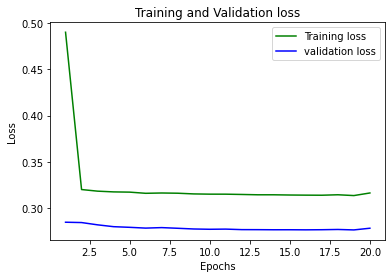

In [36]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_val)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

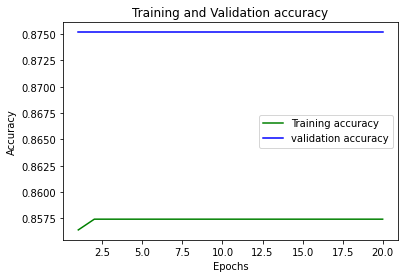

In [40]:
history.history
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

# loss_train = history.history['mean_io_u']
# loss_val = history.history['val_mean_io_u']
epochs = range(1,len(loss_val)+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# model.save('RT_fully_trained.hdf5')

30


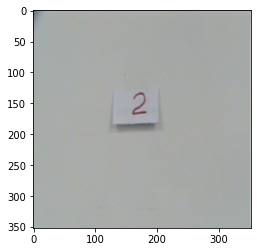

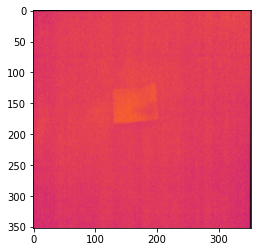

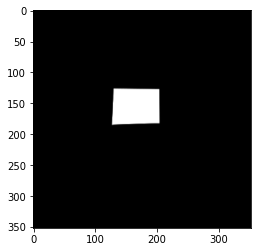

In [89]:
import random

index=random.randint(0,len(X_test))
img=X_test[index]
mask=y_test[index]
img_t=X_test_t[index]
print(index)

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show();
plt.imshow(img_t)
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

In [90]:
# x_input=[img

x=np.array([img])
x_t=np.array([img_t])
y_output=model.predict([x,x_t])
# plt.imshow(y_output[0],cmap='gray')

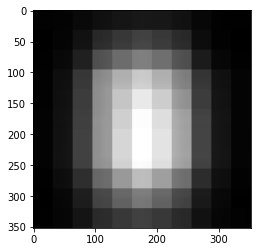

In [91]:
# temp=y_output[0]>=0.45
plt.imshow(y_output[0],cmap='gray')
plt.show()